In [49]:
from luigi.contrib.external_program import ExternalProgramTask
from luigi.parameter import IntParameter, Parameter
from luigi import LocalTarget, Task
from matplotlib import pyplot as plt
%matplotlib inline
import pandas
from wordcloud import WordCloud
import nltk

<img src="slides/title.png">

# About this Talk

- Interactively build a model that classifies internet posts
- Get a glimpse of production-readiness
- Learn about Luigi pipelines and their main components
- Write your production ready pipeline
- Get an overview of luigis modules
  
    


# Building the model interactively

## Download dataset

In [11]:
!mkdir -p dataset
!curl -L -o dataset/dataset.zip http://plainpixels.work/resources/datasets/reddit_ds_got.zip
!unzip -u -q -d dataset/reddit dataset/dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  318k  100  318k    0     0   217k      0  0:00:01  0:00:01 --:--:--  217k


In [12]:
!ls dataset/reddit

02-19-2018 02-20-2018 02-21-2018 02-22-2018 __MACOSX   training


# Explore the data

In [38]:
dataset = pandas.read_csv("dataset/reddit/training/data.csv", 
                          encoding='utf-8', 
                          sep=';').fillna('')
print(dataset.count())
print(dataset.describe())
dataset.head()

title        1000
selftext     1000
subreddit    1000
dtype: int64
                         title selftext    subreddit
count                     1000     1000         1000
unique                     999      708            2
top     Hiring Data Scientists           datascience
freq                         2      293          500


,title,selftext,subreddit
0,Weekly 'Entering & Transitioning' Thread. Ques...,**Welcome to the very first 'Entering & Transi...,datascience
1,Data Science in Fashion,,datascience
2,Evaluating our Startup using 3 versions of the...,,datascience
3,Best place to read other people's code?,"Hello,\n\nI'm starting to learn data science a...",datascience
4,What are the best practices for downloading da...,Downloading data from an API is a really commo...,datascience


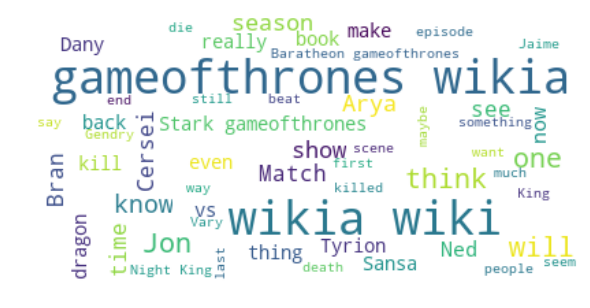

In [61]:
got = " ".join(selftext for 
               selftext in dataset[dataset["subreddit"]=="gameofthrones"].selftext)
got_wordcloud = WordCloud(min_font_size=8, 
                          max_words=100, 
                          background_color="white").generate(got)                      

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(got_wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

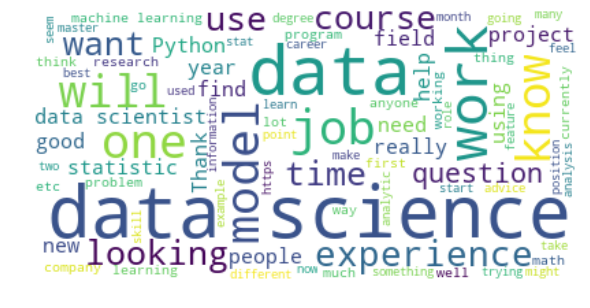

In [62]:
ds = " ".join(selftext for selftext 
              in dataset[dataset["subreddit"]=="datascience"].selftext)
ds_wordcloud = WordCloud(min_font_size=8, 
                         max_words=100, 
                         background_color="white").generate(ds) 
                     
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(ds_wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [59]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.SnowballStemmer("english")

def clean_words(post):
    tokenized = tokenizer.tokenize(post["title"] + " " + post["selftext"])
    lowercase = [word.lower() for word in tokenized]
    filtered = [word for word in lowercase if word not in stopwords]
    stemmed = [stemmer.stem(word) for word in filtered]
    return " ".join(stemmed)

dataset["cleaned_words"] = dataset.apply(clean_words, axis=1)

dataset.describe()

,title,selftext,subreddit,cleaned_words
count,1000,1000,1000,1000
unique,999,708,2,1000
top,Hiring Data Scientists,,datascience,month month member select hello frand got inte...
freq,2,293,500,1


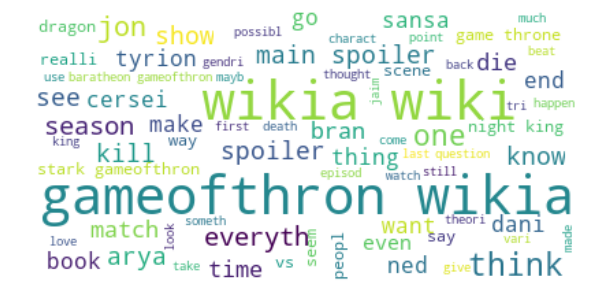

In [60]:
got_clean = " ".join(selftext for selftext 
                     in dataset[dataset["subreddit"]=="gameofthrones"].cleaned_words)
got_wordcloud_clean = WordCloud(min_font_size=8, 
                                max_words=100, 
                                background_color="white").generate(got_clean)                      

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(got_wordcloud_clean, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

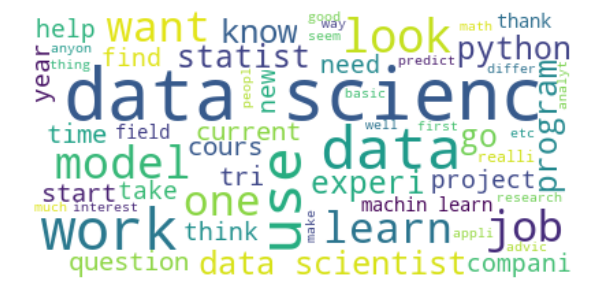

In [64]:
ds_clean = " ".join(selftext for selftext 
                    in dataset[dataset["subreddit"]=="datascience"].cleaned_words)
ds_wordcloud_clean = WordCloud(min_font_size=8, 
                               max_words=100, 
                               background_color="white").generate(ds_clean)                      

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(ds_wordcloud_clean, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [65]:
with open("dataset/reddit/training/clean.csv", "w") as out:
        dataset[["cleaned_words", "subreddit"]].to_csv(out,  encoding='utf-8', index=False, sep=';')

# Build the model

In [ ]:
# Lade die bereinigten Daten
df = sql.read.format("com.databricks.spark.csv") \
    .option("header", "true") \
    .option("delimiter", ";") \
    .load("dataset/reddit/training/clean.csv")

# Den Klassifikator trainieren
labeled = df.withColumn("label", df.subreddit.like("datascience").cast("double"))
train_set, test_set = labeled.randomSplit([0.8, 0.2])
tokenizer = Tokenizer().setInputCol("cleaned_words").setOutputCol("tokenized")
hashing = HashingTF().setNumFeatures(1000).setInputCol("tokenized").setOutputCol("features")
decision_tree = DecisionTreeClassifier()
pipeline = Pipeline(stages=[tokenizer, hashing, decision_tree])
model = pipeline.fit(train_set)

# It works, now DEPLOY it!

<img src="slides/production.png">

# A bit about Luigi 

Luigi helps to stitch long running tasks together into pipelines
    
It contains a wide toolbox of task templates (e.g. Hive, Pig, Spark, Python)

# How to compose workflows? 

A workflow consists of Tasks, Targets and Parameters

Targets correspond to a file or a database entry or some other kind of checkpoint

Tasks consume Targets of other tasks, run a computation, then output a target

Parameters take care of task parameterization

# How would our Workflow look like?

- Download the dataset

- Clean the data

- Check for existing classifier

- Classify the posts and save result

<img src="slides/luigi.png" width=75%>